**KMeans**

*Imports*

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
from sklearn.manifold import TSNE

*Downloaing the dataset:*

In [35]:
df = pd.read_excel("sofiia_diploma_flights_final.xlsx")
df = df.drop(columns=['ID', 'ICAO Departure Airport', 'ICAO Arrival Airport', 'Currency', 'Aircraft'])

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df = df.drop(columns=['Date'])
print(df.head())

   Route  Net Price  Gross Price  Profit         Departure City  \
0  there      38955        40876    1921                 Warsaw   
1   back      38955        40876    1921                   Sion   
2  there      39941        40755     814      London (Northolt)   
3   back      39941        40755     814                 Geneva   
4  there      64197        65362    1165  Dubai (World Central)   

        Arrival City  Num of Pax     Aircraft Type  Distance Trip Type  Month  \
0               Sion           4           Midsize   1198.21  Business      5   
1             Warsaw           4           Midsize   1198.21  Business      5   
2             Geneva           2             Light    762.27  Business      2   
3  London (Northolt)           2             Light    762.27  Business      2   
4             Jeddah           3  Ultra Long Range   1677.18  Business      6   

   DayOfWeek  
0          6  
1          4  
2          3  
3          2  
4          2  


*Transformation of categorical features and data scaling*

In [36]:
df = df.drop(columns=['Departure City', 'Arrival City'])

df['Trip Type'] = df['Trip Type'].map({'Business': 0, 'Vacation': 1})
df['Route'] = df['Route'].map({'there': 0, 'back': 1})


aircraft_mapping = {
    "Turboprob": 0,
    "Entry Level": 1,
    "Light": 2,
    "Super Light": 3,
    "Midsize": 4,
    "Super Midsize": 5,
    "Heavy": 6,
    "Ultra Long Range": 7,
    "VIP Airliner": 8
}
df['Aircraft Type'] = df['Aircraft Type'].map(aircraft_mapping)

num_cols = ['Net Price', 'Gross Price', 'Profit', 'Distance']
descrete_cols = ['Aircraft Type', 'Trip Type', 'Route', 'Num of Pax', 'Month', 'DayOfWeek']


scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler(feature_range=(-1, 1))

df_mixed = df.copy()
df_mixed[num_cols] = scaler_standard.fit_transform(df[num_cols])
df_mixed[descrete_cols] = scaler_minmax.fit_transform(df[descrete_cols])

print("Original data:")
print(df.head(), "\n")

print("Scaled data:")
print(df_mixed.head())

Original data:
   Route  Net Price  Gross Price  Profit  Num of Pax  Aircraft Type  Distance  \
0      0      38955        40876    1921           4              4   1198.21   
1      1      38955        40876    1921           4              4   1198.21   
2      0      39941        40755     814           2              2    762.27   
3      1      39941        40755     814           2              2    762.27   
4      0      64197        65362    1165           3              7   1677.18   

   Trip Type  Month  DayOfWeek  
0          0      5          6  
1          0      5          4  
2          0      2          3  
3          0      2          2  
4          0      6          2   

Scaled data:
   Route  Net Price  Gross Price    Profit  Num of Pax  Aircraft Type  \
0   -1.0   0.059625     0.080590  1.197013    0.333333           0.00   
1    1.0   0.059625     0.080590  1.197013    0.333333           0.00   
2   -1.0   0.092315     0.076618 -0.820809   -1.000000          -0

*Silhouette Score:*

Silhouette Score


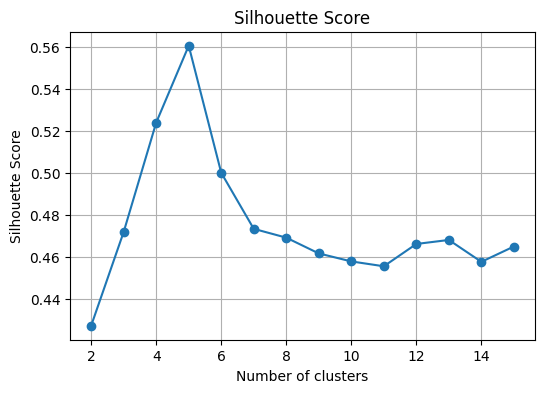

In [37]:
feature_sets = {
    "final": ["Trip Type", "Distance", "Route", "Aircraft Type"]
}

def evaluate_clustering_multiple_clusters(features, cluster_range=(2, 15)):
    results = []
    X = df_mixed[features]

    for n_clusters in range(cluster_range[0], cluster_range[1] + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        sil_score = silhouette_score(X, labels)

        results.append({
            "Feature Set": ", ".join(features),
            "Num Clusters": n_clusters,
            "Silhouette Score": sil_score
        })

    return results

all_results = []
for name, features in feature_sets.items():
    all_results.extend(evaluate_clustering_multiple_clusters(features))

results_df = pd.DataFrame(all_results)

tools.display_dataframe_to_user(name="Silhouette Score", dataframe=results_df[['Feature Set', 'Num Clusters', 'Silhouette Score']])

for feature_set in results_df["Feature Set"].unique():
    subset = results_df[results_df["Feature Set"] == feature_set]

    plt.figure(figsize=(6, 4))

    plt.plot(subset["Num Clusters"], subset["Silhouette Score"], marker='o', linestyle='-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score")
    plt.grid(True)

    plt.show()

*Elbow method:*

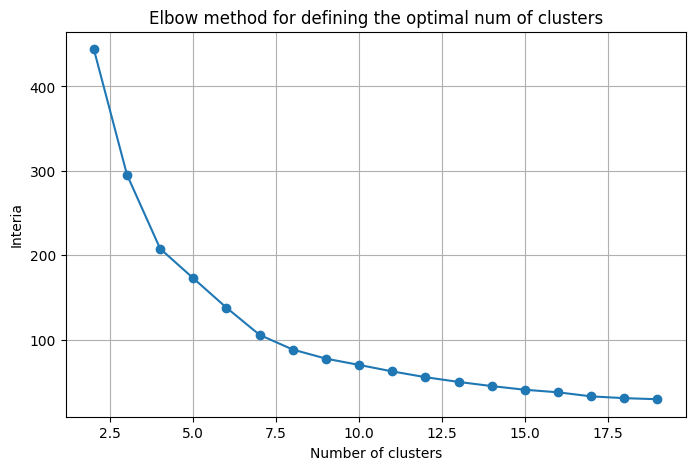

In [38]:
selected_features = ["Trip Type", "Distance", "Aircraft Type", "Route"]
X = df_mixed[selected_features]

inertia = []
cluster_range = range(2, 20)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('Interia')
plt.title('Elbow method for defining the optimal num of clusters')
plt.grid()
plt.show()

*Clusters characteristics:*

In [39]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_mixed["Cluster"] = kmeans.fit_predict(X)

cluster_summary = df_mixed.groupby("Cluster")[selected_features].agg(["min", "max", "mean", "median"])
cluster_counts = df_mixed["Cluster"].value_counts().sort_index()
cluster_summary["Count"] = cluster_counts

tools.display_dataframe_to_user(name="Cluster Characteristics", dataframe=cluster_summary)

required_columns = ['Cluster', 'Aircraft Type']

Cluster Characteristics


*Visualization of clasters in 2D using t-SNE*

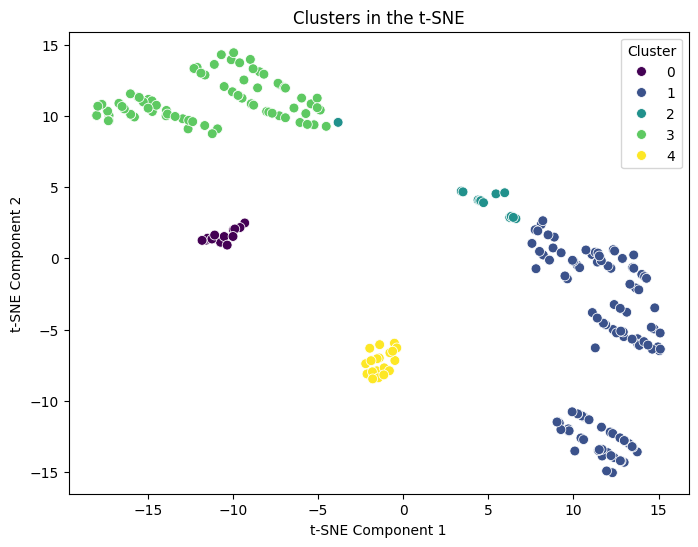

In [40]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

df_mixed["t-SNE_1"] = X_tsne[:, 0]
df_mixed["t-SNE_2"] = X_tsne[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_mixed["t-SNE_1"], y=df_mixed["t-SNE_2"], hue=df_mixed["Cluster"], palette="viridis", s=50)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Clusters in the t-SNE")
plt.legend(title="Cluster")
plt.show()

*Characteristics of financial features for each cluster:*

In [41]:
financial_features = ["Net Price", "Gross Price", "Profit"]
cluster_financial_summary = df_mixed.groupby("Cluster")[financial_features].agg(["min", "max", "mean", "median"])

tools.display_dataframe_to_user(name="Cluster Financial Characteristics", dataframe=cluster_financial_summary)

Cluster Financial Characteristics


*Visualization of financial features for each cluster:*

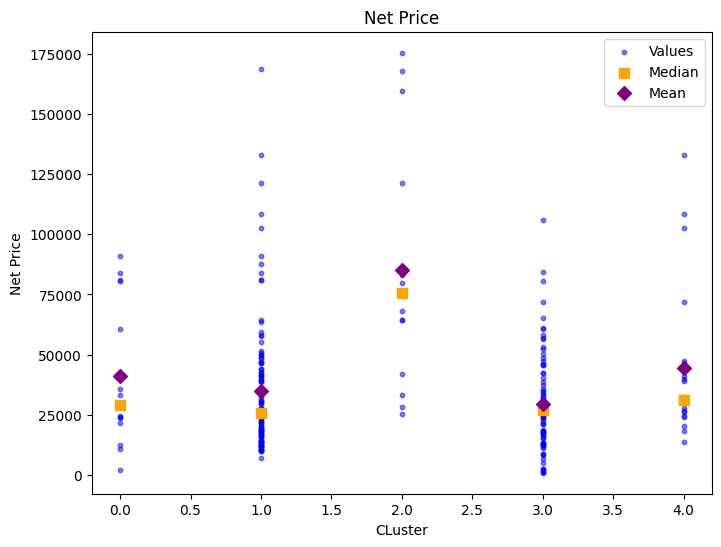

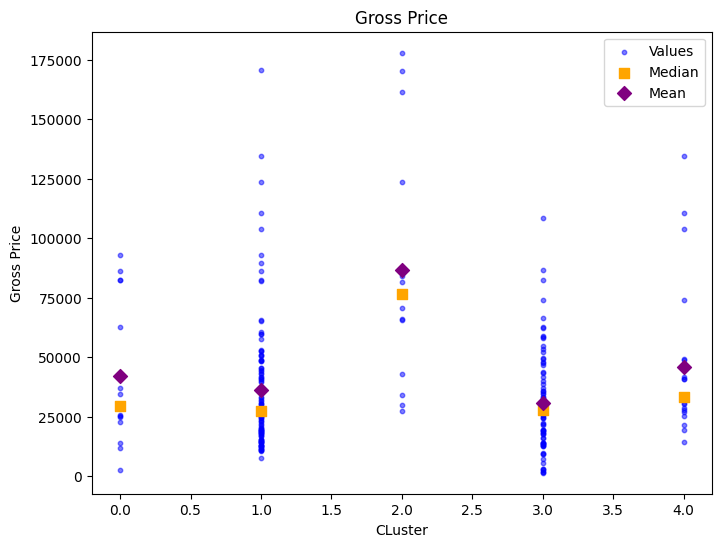

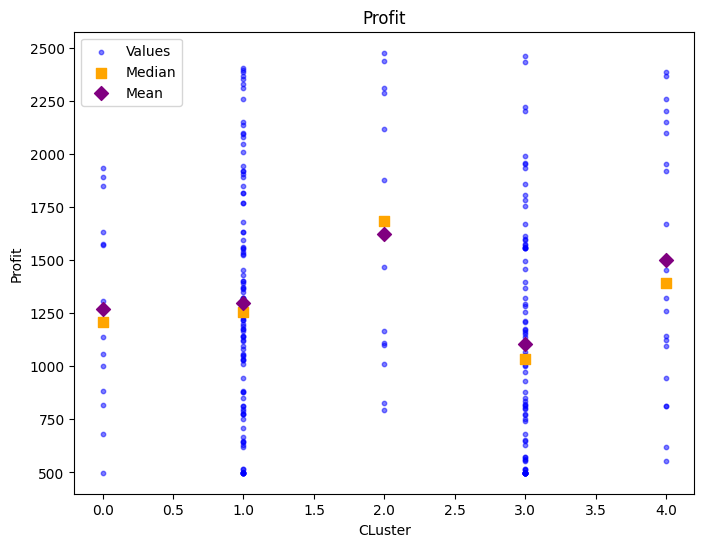

In [42]:
financial_means = {
    "Net Price": 37156.582329,
    "Gross Price": 38420.887550,
    "Profit": 1264.305221
}

financial_stds = {
    "Net Price": 30223.025387,
    "Gross Price": 30525.547796,
    "Profit": 549.716403
}

#X = X0 * st.d. + mean
df_unscaled = df_mixed.copy()
for feature in financial_features:
    df_unscaled[feature] = df_mixed[feature] * financial_stds[feature] + financial_means[feature]

cluster_financial_stats = df_unscaled.groupby("Cluster")[financial_features].agg(["min", "max", "median", "mean"])


for feature in financial_features:
    plt.figure(figsize=(8, 6))
    clusters = df_unscaled["Cluster"].unique()

    for cluster in clusters:
        cluster_values = df_unscaled[df_unscaled["Cluster"] == cluster][feature]
        plt.scatter([cluster] * len(cluster_values), cluster_values, color='blue', alpha=0.5, s=10, label="Values" if cluster == 0 else "")

    medians = cluster_financial_stats[(feature, "median")]
    means = cluster_financial_stats[(feature, "mean")]

    for cluster in clusters:
        plt.scatter(cluster, medians[cluster], color='orange', marker='s', s=50, label='Median' if cluster == 0 else "")
        plt.scatter(cluster, means[cluster], color='purple', marker='D', s=50, label='Mean' if cluster == 0 else "")

    plt.title(f"{feature}")
    plt.xlabel("CLuster")
    plt.ylabel(feature)
    plt.legend()
    plt.show()
